<a href="https://colab.research.google.com/github/Ayavie/Airbnb_price_category_prediction./blob/main/Airbnb_price_category_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#✔️ Problem Formulation:
We need to predict the price and type of an aparement/house (Target variables) of airbnb company based on its overview summary and image (Independent variables). The price is encoded into 3 classes [0,1,2] so we'll work on it with classification methods.
In this problem we can mainly use CONVNETS for images and for the summary overview we can use sequential models like GRU and LSTMs.

The challenges that would be faced could be finding the best way (Model) to deal we both images and text at the same time and of course the hyperparameter tuning.


#✔️ Strategy used:

1. Importing libraries and Investigation data
2. Building a model with CONV Nets
3. tune the previous model
4. GRU Model
4. LSTM Model
5. Bidirectional LSTMs Model
6. Work with RGB images instead of grayscale and implement multi-task by predicting both target variables.
**Note:** Multi-modality is used in all the trials and dropout is used in multiple models.

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c cisc-873-dm-f22-a4
! unzip -q cisc-873-dm-f22-a4.zip

 99% 597M/604M [00:05<00:00, 122MB/s]
100% 604M/604M [00:05<00:00, 107MB/s]


# Importing libraries and investigating data

In [ ]:
import os
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import pandas as pd
import os
import numpy as np
from ast import literal_eval

In [ ]:
#Reading data
df=pd.read_csv('/content/a4/train_xy.csv')
df_test=pd.read_csv('/content/a4/test_x.csv')

In [ ]:
#Printing few lines of the data
df.head(5)

,summary,image,type,price
0,"Spacious, sunny and cozy modern apartment in t...",img_train/0.jpg,Apartment,1
1,Located in one of the most vibrant and accessi...,img_train/1.jpg,Apartment,0
2,Logement coquet et douillet à 10 minutes du ce...,img_train/2.jpg,Apartment,1
3,"Beautiful and spacious (1076 sc ft, / 100 mc) ...",img_train/3.jpg,Apartment,1
4,Très grand appartement ''rustique'' et très ag...,img_train/4.jpg,Apartment,0


In [ ]:
# Print dataframe size 
df.shape

(7627, 4)

In [ ]:
#Checking for nans 
df.isna().sum()

summary    301
image        0
type         0
price        0
dtype: int64

In [ ]:
#Checking for duplicates
df.duplicated().sum()

0

# Data Preprocessing

First, let's encode the 'type' column.

In [ ]:
df['type']=df['type'].astype('category').cat.codes

# Get number of unique values on target variables 'type' and 'price'

len_type=df['type'].nunique()
len_price=df.price.nunique()

print (len_type)
print (len_price)

24
3


In [ ]:
df['type']

0        1
1        1
2        1
3        1
4        1
        ..
7622     1
7623     1
7624     1
7625     1
7626    17
Name: type, Length: 7627, dtype: int8

Since we have text and image files we'll have different preprocessing for each.


**Image data:** Resize

**Text data:** Tokenization and convert to integer IDs

In [ ]:
# preprocess image data
import os
#'/content/a4/img_train/100.jpg'
def load_image(file):
    try:
        image = Image.open(
            file
        ).convert('LA').resize((64, 64))
        arr = np.array(image)
    except:
        arr = np.zeros((64, 64, 2))
    return arr


# loading images:
x_train_image = np.array([load_image(i) for i in tqdm('/content/a4/'+df.image)])

# loading overview: (force convert some of the non-string cell to string)
x_train_text = df.summary.astype('str')

# get type
y_train_type = df['type']

# get language
y_train_price = df.price

  0%|          | 0/7627 [00:00<?, ?it/s]

In [ ]:
y_train_type.unique()

array([ 1, 17, 22, 10, 18, 20,  5,  2,  8,  4, 23, 13, 15, 16, 14, 11, 19,
        0, 21,  3,  6, 12,  7,  9], dtype=int8)

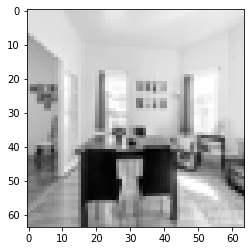

In [ ]:
# check image loading
import matplotlib.pyplot as plt
plt.imshow(x_train_image[0, :, :, 0],cmap='gray');
#[no of images,rows,columns,channels]

In [ ]:
# preprocess text data

import tensorflow as tf
tf.random.set_seed(1234)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pprint import pprint

vocab_size = 40000
max_len = 100


# build vocabulary from training set
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train_text)


def _preprocess(list_of_text):
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text),
        maxlen=max_len,
        padding='post',
    )
    
#x_vl_text_id = _preprocess(x_vl_text)
# padding is done inside: 
x_train_text_id = _preprocess(x_train_text)

print(x_train_text_id.shape)

(7627, 100)


In [ ]:
# we can use the tokenizer to convert IDs to words.
pprint(tokenizer.sequences_to_texts(x_train_text_id[:5]))

['spacious sunny and cozy modern apartment in the heart of montreal this 3 '
 'bedroom centrally located in the very popular plateau mont royal '
 'neighborhood in the middle of prince arthur pedestrian only street close to '
 'all amenities restaurants coffee house bars clubs shopping universities '
 'subway stations experience montreal like a real local resident be in the '
 'heart of the action grand prix week grill saint laurent festival mural 2019 '
 'and so much more',
 'located in one of the most vibrant and accessible locations of downtown '
 'montreal this one bedroom condo will not only impress you but leave you with '
 'one of the most memorable experiences it is walking distance of the popular '
 'sainte catherine street the bell center the old port lachine canal '
 'bonaventure metro and much much more',
 'logement coquet et douillet à 10 minutes du centre ville de montréal '
 'épicerie pharmacie saq restaurants et transports en communs à proximité deux '
 'chambres fermée

In [ ]:
print('total words in the dictionary:', tokenizer.num_words)

total words in the dictionary: 40000


# Building a Learning model

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.optimizers import Adam,Nadam


# here we have two inputs. one for image and the other for text.
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
# simple average of embedding of 100 vector space
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)
averaged = tf.reduce_mean(embedded, axis=1)


# simple conv2d of 64 filter each of dimension 16x16
cov = Conv2D(64, (16, 16))(in_image)
pl = MaxPool2D((16, 16))(cov)
flattened = Flatten()(pl)


# fusion - combinig both
fused = tf.concat([averaged, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.5,
        'price': 0.5,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 49, 49, 64)   32832       ['input_8[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 100, 100)     4000000     ['input_7[0][0]']                
                                                                                            

## Model Training


In [ ]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=8,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5 )
    ],
    verbose=1
)

Epoch 1/20
763/763 [==============================] - 106s 137ms/step - loss: 34.9493 - price_loss: 24.9288 - type_loss: 44.9698 - price_sparse_categorical_accuracy: 0.5030 - type_sparse_categorical_accuracy: 0.5788 - val_loss: 11.1034 - val_price_loss: 6.8935 - val_type_loss: 15.3132 - val_price_sparse_categorical_accuracy: 0.5210 - val_type_sparse_categorical_accuracy: 0.7588
Epoch 2/20
763/763 [==============================] - 104s 137ms/step - loss: 24.4659 - price_loss: 16.9513 - type_loss: 31.9804 - price_sparse_categorical_accuracy: 0.5070 - type_sparse_categorical_accuracy: 0.5794 - val_loss: 12.5444 - val_price_loss: 9.1929 - val_type_loss: 15.8960 - val_price_sparse_categorical_accuracy: 0.5498 - val_type_sparse_categorical_accuracy: 0.6579
Epoch 3/20
763/763 [==============================] - 105s 138ms/step - loss: 17.3771 - price_loss: 12.9249 - type_loss: 21.8294 - price_sparse_categorical_accuracy: 0.5266 - type_sparse_categorical_accuracy: 0.5876 - val_loss: 19.8631 - 

## Data Preprocessing (Testing)

Here we use the trained tokenizer to pre-process the testing set.

In [ ]:
# loading images:
x_test_image = np.array([load_image(i) for i in tqdm('/content/a4/img_test'+df_test.image)])

# loading overview: (force convert some of the non-string cell to string)
x_test_text = _preprocess(df_test.summary.astype('str'))

  0%|          | 0/7360 [00:00<?, ?it/s]

## Predition

We can use the model to predict the testing samples.

In [ ]:
# Predition
# we can do prediction on training set
y_predict = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
price_predicted = y_predict['price']
print(price_predicted)

# categories
price_category_predicted = np.argmax(price_predicted, axis=1)
print(price_category_predicted)


# probabilities
type_predicted = y_predict['type']
print(type_predicted)

# categories
type_category_predicted = np.argmax(type_predicted, axis=1)
print(type_category_predicted)

[[9.9998534e-01 1.2281947e-05 2.3399277e-06]
 [9.9999988e-01 6.7015804e-08 4.3859996e-09]
 [9.9999547e-01 3.9835127e-06 5.5218032e-07]
 ...
 [9.9999011e-01 9.1166512e-06 8.1292166e-07]
 [9.9999917e-01 5.7448830e-07 2.0731281e-07]
 [9.8818654e-01 1.0353884e-02 1.4595252e-03]]
[0 0 0 ... 0 0 0]
[[4.9345155e-05 9.6392715e-01 7.3831617e-03 ... 1.0564625e-03
  8.4778474e-04 1.5745675e-03]
 [1.6645218e-07 9.9907148e-01 3.2894753e-04 ... 1.8463170e-05
  1.1124245e-05 3.1386699e-05]
 [1.3912692e-05 9.8311317e-01 4.1191201e-03 ... 4.3900666e-04
  3.2544110e-04 7.0028234e-04]
 ...
 [7.8321564e-06 9.9026674e-01 2.4510575e-03 ... 2.6638573e-04
  1.6752660e-04 4.3527939e-04]
 [3.8493730e-05 9.5760429e-01 8.9410516e-03 ... 1.0536334e-03
  1.0674949e-03 1.5115512e-03]
 [5.1659008e-04 9.1550326e-01 9.8935943e-03 ... 3.6222304e-03
  2.4211768e-03 4.5992858e-03]]
[1 1 1 ... 1 1 1]


In [ ]:
# Submission file
pd.DataFrame(
    {'id': df_test.id,
     'price': price_category_predicted}
).to_csv('sample_submission_org.csv', index=False)

##Observation 1:
The model got 0.67472 testing accuracy.

The same model was tried with Nadam optimizer and got testing accuracy:  0.65027


# Building Another Learning Model with conv layer of more filters
**Expecation**: Adding more filters makes the model able to extract more features and end up with better accuracy!

In [ ]:
# here we have two inputs. one for image and the other for text.
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
# simple average of embedding. you can change it to anything else as needed
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)
averaged = tf.reduce_mean(embedded, axis=1)


# image part 
#simple conv2d of 256 filter each of dimension 16x16
cov = Conv2D(256, (16, 16))(in_image)
pl = MaxPool2D((16, 16))(cov)

flattened = Flatten()(pl)


# fusion - combinig both
fused = tf.concat([averaged, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.5,
        'price': 0.5,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

## Model Training

Based on the training/validation performance, you can adjust the epochs to be trained. Early stoping is watching the validation loss on price prediction (assuming that it is the main task we would like to perform)

In [ ]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5 )
    ],
    verbose=1
)

Epoch 1/20
382/382 [==============================] - 194s 506ms/step - loss: 107.9382 - price_loss: 66.6303 - type_loss: 149.2462 - price_sparse_categorical_accuracy: 0.4970 - type_sparse_categorical_accuracy: 0.5727 - val_loss: 29.3927 - val_price_loss: 12.8829 - val_type_loss: 45.9026 - val_price_sparse_categorical_accuracy: 0.5216 - val_type_sparse_categorical_accuracy: 0.7366
Epoch 2/20
382/382 [==============================] - 192s 502ms/step - loss: 89.6745 - price_loss: 54.3005 - type_loss: 125.0486 - price_sparse_categorical_accuracy: 0.5002 - type_sparse_categorical_accuracy: 0.5750 - val_loss: 59.4388 - val_price_loss: 40.2523 - val_type_loss: 78.6253 - val_price_sparse_categorical_accuracy: 0.6252 - val_type_sparse_categorical_accuracy: 0.7608
Epoch 3/20
382/382 [==============================] - 191s 500ms/step - loss: 91.9172 - price_loss: 51.0369 - type_loss: 132.7975 - price_sparse_categorical_accuracy: 0.5206 - type_sparse_categorical_accuracy: 0.5822 - val_loss: 202.

## Predition

We can use the model to predict the testing samples.

In [ ]:
# Predition
# we can do prediction on training set
y_predict = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
price_predicted = y_predict['price']
print(price_predicted)

# categories
price_category_predicted = np.argmax(price_predicted, axis=1)
print(price_category_predicted)


# probabilities
type_predicted = y_predict['type']
print(type_predicted)

# categories
type_category_predicted = np.argmax(type_predicted, axis=1)
print(type_category_predicted)

In [ ]:
# Submission file
pd.DataFrame(
    {'id': df_test.id,
     'price': price_category_predicted}
).to_csv('sample_submission_org2.csv', index=False)

##Observation 2:
The model got 0.61141 testing accuracy so maybe this is the the correct solution for the problem.

#Sequence Models!
**Expectation**: These models are supposed to keep some of the previous information provided to the model as input so we can expect for both GRUs and LSTMs to be better but GRU to be faster in training.

#Gated Recurrent Unit GRU Model


In [ ]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# The next comments are used from the documentation of the model.
# GRU paramerters:
# units: a positive integer, dimensionality of the output space.
# activation: Activation function to use. Default: hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
# recurrent_activation: Activation function to use for the recurrent step. Default: sigmoid (sigmoid). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
# dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs. Default: 0.
# recurrent_dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state. Default: 0.
# return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)
gru = keras.layers.GRU(128, 
                       activation="tanh",
                       recurrent_activation="sigmoid",
                       return_sequences=True,
                       dropout=0.1,
                       recurrent_dropout=0.1)(embedded)
gru2 = keras.layers.GRU(128, 
                        activation="tanh",
                        recurrent_activation="sigmoid",
                        return_sequences=True,
                        dropout=0.3,
                        recurrent_dropout=0.1)(gru)
gru3 = keras.layers.GRU(64, 
                        activation="tanh",
                        recurrent_activation="sigmoid",
                        return_sequences=False,
                        dropout=0.2,
                        recurrent_dropout=0.1)(gru2)

# simple conv2d of 32 filter each of dimension 16x16
cov = Conv2D(32, (16, 16))(in_image)
pl = MaxPool2D((16, 16))(cov)
flattened = Flatten()(pl)

# fusion:
fused = tf.concat([gru3, flattened], axis=-1)

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused)
p_type = Dense(len_type, activation='softmax', name='type')(fused)


model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'price': p_price,
        'type': p_type,
    },
)


model.compile(
    optimizer=Adam(),
    loss={
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'price': 0.5,
        'type': 0.5,       
    },
    metrics={
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

## GRU Model Training

In [ ]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5 )
    ],
    verbose=1
)

Epoch 1/20
382/382 [==============================] - 303s 771ms/step - loss: 23.1529 - price_loss: 19.9381 - type_loss: 26.3678 - price_sparse_categorical_accuracy: 0.4916 - type_sparse_categorical_accuracy: 0.5889 - val_loss: 7.7193 - val_price_loss: 6.7265 - val_type_loss: 8.7120 - val_price_sparse_categorical_accuracy: 0.5465 - val_type_sparse_categorical_accuracy: 0.4535
Epoch 2/20
382/382 [==============================] - 296s 775ms/step - loss: 8.4008 - price_loss: 6.0848 - type_loss: 10.7168 - price_sparse_categorical_accuracy: 0.5130 - type_sparse_categorical_accuracy: 0.5830 - val_loss: 5.9851 - val_price_loss: 3.8243 - val_type_loss: 8.1459 - val_price_sparse_categorical_accuracy: 0.5393 - val_type_sparse_categorical_accuracy: 0.7025
Epoch 3/20
382/382 [==============================] - 297s 778ms/step - loss: 8.8491 - price_loss: 6.6420 - type_loss: 11.0562 - price_sparse_categorical_accuracy: 0.5076 - type_sparse_categorical_accuracy: 0.5870 - val_loss: 5.1938 - val_price

## Predition

We can use the model to predict the testing samples.

In [ ]:
# Predition
# we can do prediction on training set
y_predict = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
price_predicted = y_predict['price']
print(price_predicted)

# categories
price_category_predicted = np.argmax(price_predicted, axis=1)
print(price_category_predicted)


[[0.87295383 0.0645676  0.06247856]
 [0.8662768  0.071761   0.0619622 ]
 [0.8735058  0.06453957 0.06195467]
 ...
 [0.8746613  0.06452443 0.0608143 ]
 [0.8721485  0.06478656 0.06306493]
 [0.874117   0.06483705 0.06104586]]
[0 0 0 ... 0 0 0]


In [ ]:
# Submission file
pd.DataFrame(
    {'id': df_test.id,
     'price': price_category_predicted}
).to_csv('sample_submission_GRU.csv', index=False)

## Observation 3: 
GRU Model got testing accuracy of score: 0.53125 which is even worse than the main model.

Score: 0.58940

#Long Short Term Memory (LSTM)

In [ ]:
# Long Short Term Memory (LSTM)
# Long Short Term Memory networks – usually just called “LSTMs”
# are a special kind of RNN, capable of learning long-term dependencies.

in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# The next comments are used from the documentation of the model.
# LSTM parameters:
# units: Positive integer, dimensionality of the output space.
# activation: Activation function to use. Default: hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
# recurrent_activation: Activation function to use for the recurrent step. Default: sigmoid (sigmoid). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
# dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs. Default: 0.
# return_sequences: Boolean. Whether to return the last output. in the output sequence, or the full sequence. Default: False.
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)
lstm = keras.layers.LSTM(128, 
                         activation="tanh",
                         recurrent_activation="sigmoid",
                         return_sequences=True,
                         dropout=0.1,
                         recurrent_dropout=0.1)(embedded)
lstm2 = keras.layers.LSTM(64, 
                         activation="tanh",
                         recurrent_activation="sigmoid",
                         return_sequences=True,
                         dropout=0.2,
                         recurrent_dropout=0.1)(lstm)
lstm3 = keras.layers.LSTM(64, 
                         activation="tanh",
                         recurrent_activation="sigmoid",
                         return_sequences=False,
                         dropout=0.2,
                         recurrent_dropout=0.1)(lstm2)


# simple conv2d of 64 filter each of dimension 16x16
cov = Conv2D(64, (16, 16))(in_image)
pl = MaxPool2D((16, 16))(cov)
flattened = Flatten()(pl)

# fusion:
fused = tf.concat([lstm3, flattened], axis=-1)

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused)
p_type = Dense(len_type, activation='softmax', name='type')(fused)

model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'price': p_price,
        'type': p_type,
    },
)

model.compile(
    optimizer=Adam(),
    loss={
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'price': 0.5,
        'type': 0.5,       
    },
    metrics={
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 100, 100)     4000000     ['input_13[0][0]']               
                                                                                                  
 input_14 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 100, 128)     117248      ['embedding_6[0][0]']            
                                                                                            

## LSTM Model Training

In [ ]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5 )
    ],
    verbose=1
)

Epoch 1/20
382/382 [==============================] - 288s 730ms/step - loss: 38.9982 - price_loss: 26.9335 - type_loss: 51.0629 - price_sparse_categorical_accuracy: 0.5035 - type_sparse_categorical_accuracy: 0.5819 - val_loss: 11.7713 - val_price_loss: 9.0625 - val_type_loss: 14.4802 - val_price_sparse_categorical_accuracy: 0.3768 - val_type_sparse_categorical_accuracy: 0.6402
Epoch 2/20
382/382 [==============================] - 279s 731ms/step - loss: 13.2197 - price_loss: 8.3771 - type_loss: 18.0623 - price_sparse_categorical_accuracy: 0.5137 - type_sparse_categorical_accuracy: 0.5835 - val_loss: 8.8694 - val_price_loss: 5.8454 - val_type_loss: 11.8934 - val_price_sparse_categorical_accuracy: 0.5085 - val_type_sparse_categorical_accuracy: 0.7418
Epoch 3/20
382/382 [==============================] - 276s 722ms/step - loss: 12.8447 - price_loss: 8.7468 - type_loss: 16.9425 - price_sparse_categorical_accuracy: 0.5135 - type_sparse_categorical_accuracy: 0.5917 - val_loss: 6.8195 - val_

## Predition

We can use the model to predict the testing samples.

In [ ]:
# Predition
# we can do prediction on training set
y_predict = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
price_predicted = y_predict['price']
print(price_predicted)

# categories
price_category_predicted = np.argmax(price_predicted, axis=1)
print(price_category_predicted)


[[0.24092525 0.43227267 0.32680205]
 [0.99025106 0.00621859 0.0035303 ]
 [0.24092528 0.4322727  0.32680205]
 ...
 [0.24092528 0.4322727  0.32680205]
 [0.24092528 0.4322727  0.32680205]
 [0.24092528 0.4322727  0.32680205]]
[1 0 1 ... 1 1 1]


In [ ]:
# Submission file
pd.DataFrame(
    {'id': df_test.id,
     'price': price_category_predicted}
).to_csv('sample_submission_LSTM.csv', index=False)

##Observation 4:
The model got testing score of accuracy: 0.62038

#Bidirectional RNN
**Expectations:** It is supposed to work even better than GRUs and LSTMs as it is taking the input in a forward direction, and the other in a backwards direction which makes it capture part and future dependencies.

In [ ]:

in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# 
# Bidirectional LSTMs are an extension of traditional LSTMs that can improve model
# performance on sequence classification problems.
embedded = keras.layers.Embedding(tokenizer.num_words, 150)(in_text)
bidirectional = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(embedded)
bidirectional1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(bidirectional)
bidirectional2 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False))(bidirectional1)

# simple conv2d of 64 filter each of dimension 16x16
cov = Conv2D(32, (16, 16))(in_image)
pl = MaxPool2D((16, 16))(cov)
flattened = Flatten()(pl)

# fusion:
fused = tf.concat([bidirectional2, flattened], axis=-1)

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused)
p_type = Dense(len_type, activation='softmax', name='type')(fused)

model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'price': p_price,
        'type': p_type,
    },
)

model.compile(
    optimizer=Adam(),
    loss={
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'price': 0.5,
        'type': 0.5,       
    },
    metrics={
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 100, 150)     6000000     ['input_15[0][0]']               
                                                                                                  
 input_16 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 100, 256)     285696      ['embedding_7[0][0]']            
                                                                                            

## Bidirectional Model Training

In [ ]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type.to_numpy(),
        'price': y_train_price.to_numpy(),
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5 )
    ],
    verbose=1
)

Epoch 1/20
382/382 [==============================] - 379s 964ms/step - loss: 23.3396 - price_loss: 17.4313 - type_loss: 29.2479 - price_sparse_categorical_accuracy: 0.5009 - type_sparse_categorical_accuracy: 0.5822 - val_loss: 10.6979 - val_price_loss: 8.1480 - val_type_loss: 13.2478 - val_price_sparse_categorical_accuracy: 0.6219 - val_type_sparse_categorical_accuracy: 0.7621
Epoch 2/20
382/382 [==============================] - 365s 957ms/step - loss: 6.5524 - price_loss: 4.9359 - type_loss: 8.1690 - price_sparse_categorical_accuracy: 0.5294 - type_sparse_categorical_accuracy: 0.5852 - val_loss: 4.9889 - val_price_loss: 3.2465 - val_type_loss: 6.7313 - val_price_sparse_categorical_accuracy: 0.5793 - val_type_sparse_categorical_accuracy: 0.6789
Epoch 3/20
382/382 [==============================] - 369s 965ms/step - loss: 5.7872 - price_loss: 4.3354 - type_loss: 7.2390 - price_sparse_categorical_accuracy: 0.5479 - type_sparse_categorical_accuracy: 0.5930 - val_loss: 4.1525 - val_price

## Predition

We can use the model to predict the testing samples.

In [ ]:
# Predition
# we can do prediction on training set
y_predict = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
price_predicted = y_predict['price']
print(price_predicted)

# categories
price_category_predicted = np.argmax(price_predicted, axis=1)
print(price_category_predicted)


[[5.6923777e-01 3.0483732e-01 1.2592497e-01]
 [9.9999952e-01 5.1828152e-07 1.7620703e-08]
 [9.9999940e-01 5.5157147e-07 1.9026158e-08]
 ...
 [9.9999285e-01 6.7584310e-06 3.1286717e-07]
 [9.9999905e-01 9.5608664e-07 3.4208586e-08]
 [7.4724245e-01 1.9251856e-01 6.0238998e-02]]
[0 0 0 ... 0 0 0]


In [ ]:
# Submission file
pd.DataFrame(
    {'id': df_test.id,
     'price': price_category_predicted}
).to_csv('sample_submission_BI.csv', index=False)

##Observation 5:

The model got testing score of accuracy: 0.58804

# The last model will work with RGB images.

In [ ]:
# preprocess image data
import os

def load_image(file):
    try:
        image = Image.open(
            file
        ).convert('RGB').resize((64, 64,3))
        arr = np.array(image)
    except:
        arr = np.zeros((64, 64, 3))
    return arr


# loading images:
x_train_image = np.array([load_image(i) for i in tqdm('/content/a4/'+df.image)])

# loading overview: (force convert some of the non-string cell to string)
x_train_text = df.summary.astype('str')

# get type
y_train_type = df['type']

# get language
y_train_price = df.price

  0%|          | 0/7627 [00:00<?, ?it/s]

##Data Preprocessing (Training)

In [ ]:
# preprocess text data

vocab_size = 40000
max_len = 100


# build vocabulary from training set
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train_text)


def _preprocess(list_of_text):
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text),
        maxlen=max_len,
        padding='post',
    )
    
#x_vl_text_id = _preprocess(x_vl_text)
# padding is done inside: 
x_train_text_id = _preprocess(x_train_text)

print(x_train_text_id.shape)

(7627, 100)


## Building a Learning model

In [ ]:
from keras.layers import SpatialDropout2D
# here we have two inputs. one for image and the other for text.

in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 3))

# text part
# simple average of embedding of 150 vector space
embedded = keras.layers.Embedding(tokenizer.num_words, 150)(in_text)
averaged = tf.reduce_mean(embedded, axis=1)


# image part 
# simple conv2d of 64 filter each of dimension 16x16
cov = Conv2D(64, (16, 16))(in_image)
pl = MaxPool2D((16, 16))(cov)
#dropout= SpatialDropout2D(0.4) (pl)
flattened = Flatten()(pl)


# fusion - combinig both
fused = tf.concat([averaged, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.5,
        'price': 0.5,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 49, 49, 64)   49216       ['input_18[0][0]']               
                                                                                                  
 embedding_8 (Embedding)        (None, 100, 150)     6000000     ['input_17[0][0]']               
                                                                                            

In [ ]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=8,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5 )
    ],
    verbose=1
)

Epoch 1/20
763/763 [==============================] - 143s 187ms/step - loss: 0.9633 - price_loss: 0.8282 - type_loss: 1.0985 - price_sparse_categorical_accuracy: 0.6245 - type_sparse_categorical_accuracy: 0.7515 - val_loss: 0.8579 - val_price_loss: 0.7805 - val_type_loss: 0.9354 - val_price_sparse_categorical_accuracy: 0.6540 - val_type_sparse_categorical_accuracy: 0.7647
Epoch 2/20
763/763 [==============================] - 142s 186ms/step - loss: 0.8380 - price_loss: 0.7367 - type_loss: 0.9393 - price_sparse_categorical_accuracy: 0.6679 - type_sparse_categorical_accuracy: 0.7543 - val_loss: 0.7930 - val_price_loss: 0.7151 - val_type_loss: 0.8710 - val_price_sparse_categorical_accuracy: 0.6809 - val_type_sparse_categorical_accuracy: 0.7654
Epoch 3/20
763/763 [==============================] - 142s 187ms/step - loss: 0.7531 - price_loss: 0.6583 - type_loss: 0.8478 - price_sparse_categorical_accuracy: 0.7122 - type_sparse_categorical_accuracy: 0.7577 - val_loss: 0.7646 - val_price_loss

## Data Preprocessing (Testing)

Here we use the trained tokenizer to pre-process the testing set.

In [ ]:
# loading images:
x_test_image = np.array([load_image(i) for i in tqdm('/content/a4/img_test'+df_test.image)])

# loading overview: (force convert some of the non-string cell to string)
x_test_text = _preprocess(df_test.summary.astype('str'))

  0%|          | 0/7360 [00:00<?, ?it/s]

## Predition

We can use the model to predict the testing samples.

In [ ]:
# Predition
# we can do prediction on training set
y_predict = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
price_predicted = y_predict['price']
print(price_predicted)

# categories
price_category_predicted = np.argmax(price_predicted, axis=1)
print(price_category_predicted)


# probabilities
type_predicted = y_predict['type']
print(type_predicted)

# categories
type_category_predicted = np.argmax(type_predicted, axis=1)
print(type_category_predicted)

In [ ]:
# Submission file
pd.DataFrame(
    {'id': df_test.id,
     'price': price_category_predicted}
).to_csv('sample_submission_RGB_drp.csv', index=False)

##Observation 6:

It seems like the model worked well with RGB data with testing accuracy of value 0.67364

#Conclusion:
> The best result was achieved by the first model by using gray scale image and deep learning model of CNN layer beating sequence algorithms. LSTM was the best out of sequence models and GRU and Bidirectional got almost the same accuracy. 

> I think the reason behind that is that the sequence model were so complicated for the data that they missed up!


> Also, using RGB images didn't really make much difference in accuracy, it is almost the same as the best model.


#✔️ Answer the questions below (briefly):

🌈Is fully-connected model a good one for sequential data? Why? How about for image data? Is it good? Why?


> No, it is not good for both as the number of parameters will increase exponentially which will make the model computationally expensive and it will not be able to keep information from the previous input which is the main idea of sequence models and for images, it will not be able to extract features like convolutional layers and that's why it is only used to combine the upper layer features.


🌈What is gradient vanishing and gradient explosion, and how GRU/LSTM tries to mitigate this problem?


> In NN's backprobagation function the derivatives will be multiplied. If the derivatives are of large values then the gradient will increase exponentially as we propagate down the model until they eventually explode, that's why it is called exploding gradient. On the other hand, if the derivatives are small then the gradient will decrease exponentially as we propagate through the model until it eventually vanishes, and that's the vanishing gradient problem.

>GRU's and LSTMs mitigated this problem by having gatesin their architecture in which these gates can learn which data in a sequence is important to keep or forget. By doing so, it can pass relevant information down the the model of RNNs to make predictions. Almost all state of the art results based on recurrent neural networks are achieved with these two networks. 



🌈What is multi-objective/multi-task learning? What is multi-modality learning? 
How do you use them in this assignment?



> **Multi-task learning** is an approach in machine learning in which we build one model to predict more than one target variable by specifying the feature and target variables and then the model is able to predict both at the same time instead of buidling 2 separate models. It improves model performance when there are common information to be learned, for example trying to detect animals so that the model is trying to extract the same features.

> **Multi-modality** is learning from different sources (Image/Text) to target one or 2 dependent variables.


> Multi-modality is achieved as our model is learning from images and text data.
If we were to predict both type and price then that's multi-task learning.


🌈What is the difference among xgboost, lightgbm and catboost

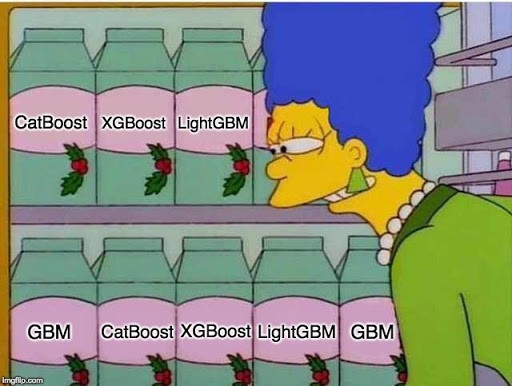

> The algorithms differ from each other in the implementation of the boosted trees algorithm and their technical compatibilities and limitations. Before learning, all algorithms create feature-split pairs for all features

 XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. 

**XgBoosting**: 
• Fast – optimized for multi-threading/processing

• Doesn't handle categorical feature encoding, must be done manually first.

• Additional regularization


**Light GBM** is  faster than XGBoost
• Lower memory consumption

• Can reach even lower bias on a larger dataset

• Higher risk of overfitting

• Gradient-based One-Side Sampling (GOSS)

• Down-sample instances based on the gradient

• Happened during split

• High gradient -> high bias -> higher chance

• Small gradient -> small bias -> lower chance

• it selects the samples that are causing more errors to estimate split

**CatBoost**

• Specifically design for categorical features

• A better and flexible approach to automatically encode
categorical features

• Categorical feature -> numeric feature

• Work on GPU


**Missing values handling:** Catboost has two modes for processing missing values, “Min” and “Max”. In which when choosing min it is less than all the values, and the opposite with max.
In LightGBM and XGBoost missing values are allocated to the side that reduces the loss in each split.


**References:**

https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/

https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc 